In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import time

from threading import Thread
from threading import Lock

import multiprocessing

from sklearn.model_selection import train_test_split 

from src.Images import preprocess_images_from_dir
from src.Images import get_all_images_path
from src.Images import read_processed_image
from src.Images import plot_image
from src.Images import flatten_to_image

from src.Distances import euclidean_distance

from src.Knn import Knn


WORKSPACE = os.path.curdir
DATASET_DIR = os.path.join(WORKSPACE, "dataset")
IMAGES_DIR = os.path.join(DATASET_DIR, "dataset")
PROCESSED_IMAGES_PATH = os.path.join(IMAGES_DIR, "_processed")

N_ROWS = 16
N_COLUMNS = 16

file_lock = Lock()
correct_lock = Lock()
wrong_lock = Lock()
correct = 0
wrong = 0

In [2]:
ans = input("Are you sure you want to preprocess all images? [type 'yes']")
if ans == "yes":
    preprocess_images_from_dir(dir_path=IMAGES_DIR, n_rows=N_ROWS, n_columns=N_COLUMNS, extension="png")

Are you sure you want to preprocess all images? [type 'yes'] yes


Found 40000 image(s)
Directory ./dataset/dataset/_processed removed
Writing images...
Finished!


In [3]:
images_path = get_all_images_path(PROCESSED_IMAGES_PATH)
images_path[:5]

['./dataset/dataset/_processed/14719 flat tile corner 2x2 000L.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 000R.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 001L.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 001R.png',
 './dataset/dataset/_processed/14719 flat tile corner 2x2 002L.png']

In [4]:
data = [
    (
        int(path.split(" ")[0].split("/")[-1]),
        read_processed_image(path, N_ROWS, N_COLUMNS).flatten()
    ) for path in images_path
]


y, x = zip(*data)
x = list(x)
y = list(y)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle=True)

In [6]:
knn = Knn()

knn.add_points(list(zip(y_train, x_train)))

28000 points were added!


28000

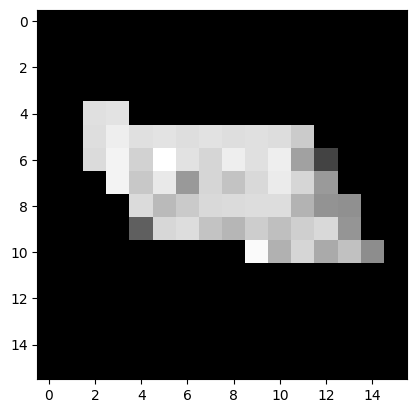

In [7]:
plot_image(flatten_to_image(x_train[5], N_ROWS, N_COLUMNS))

In [8]:

def split_data_into_chunks(data, num_chunks):
    avg_chunk_size = len(data) // num_chunks
    chunks = [data[i:i+avg_chunk_size] for i in range(0, len(data), avg_chunk_size)]
    return chunks

def thread_function(file_lock, correct_lock, wrong_lock, knn, test_data, correct, wrong):
    total_start = time.time()
    log = ""
    for point, right_answer in test_data:
        start = time.time()
        returned_answer = knn.classify(point)
        total = time.time() - start
        log += f"{right_answer},{returned_answer},{returned_answer == right_answer},{total}\n"
        
    with file_lock:
        with open(f"{N_ROWS}x{N_COLUMNS}_execution_log.csv", "a") as file:
            file.write(log)
            # file.write(f"{right_answer},{returned_answer},{returned_answer == right_answer},{total}\n")
            
        # if returned_answer == right_answer:
        #     with correct_lock:
        #         correct += 1
        # else:
        #     with wrong_lock:
        #         wrong += 1

    print(f"Total time for thread {Thread.ident}: {time.time() - total_start}s")

In [9]:
threads = []
num_threads = 4

number_of_tests_used = 100

test_data = list(zip(x_test[:number_of_tests_used], y_test[:number_of_tests_used]))
total_tests = len(test_data)

chunks = split_data_into_chunks(test_data, num_threads)

total_execution_start = time.time()

for chunk in chunks:
    thread = multiprocessing.Process(target=thread_function, args=(file_lock, correct_lock, wrong_lock, knn, chunk, correct, wrong))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Total time for all process: {time.time()-total_execution_start}s")

print(f"{correct}/{total_tests} right answers ({correct/total_tests*100}%)")
print(f"{wrong}/{total_tests} wrong answers ({wrong/total_tests*100}%)")

Total time for thread <property object at 0x7f005c2f2430>: 6.792163848876953s
Total time for thread <property object at 0x7f005c2f2430>: 6.837247848510742s
Total time for thread <property object at 0x7f005c2f2430>: 6.969717741012573s
Total time for thread <property object at 0x7f005c2f2430>: 6.978821516036987s
Total time for all process: 7.05996036529541s
0/100 right answers (0.0%)
0/100 wrong answers (0.0%)


In [10]:
# correct = 0
# wrong = 0

# test_data = list(zip(x_test[:100], y_test[:100]))

# total_tests = len(test_data)

# for point, right_answer in test_data:
#     start = time.time()
#     returned_answer = knn.classify(point)
#     total = time.time() - start
    
#     with open(f"{N_ROWS}x{N_COLUMNS}_execution_log.csv", "a") as file:
#         file.write(f"{right_answer},{returned_answer},{returned_answer == right_answer},{total}\n")
        
#     if returned_answer == right_answer:
#         correct += 1
#     else:
#         wrong += 1

# print(f"{correct}/{total_tests} right answers ({correct/total_tests*100}%)")
# print(f"{wrong}/{total_tests} wrong answers ({wrong/total_tests*100}%)")